In [1]:
import sys
sys.path.append('/home/luketaylor/PycharmProjects/BrainBox')

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from brainbox import datasets, models, trainer, metrics
from brainbox.datasets import transforms
import brainbox.physiology as phys

In [2]:
%load_ext autoreload
%autoreload 2

An aspiration of BrainBox is to simplify the creation of computational neuroscience models with plug and play datasets. The objective of this notebook is to outline how BrainBox can be used to 1. load and preprocess datasets 2. construct a model 3. train a model and 4. validate a model. In order to achieve this we will build a classic linear-nonlinear model and fit it to macaque V1 responses to natural movies. The dataset used is a processed version of the pvc-1 dataset found at https://crcns.org/data-sets/vc/pvc-1/about (Ringach and Nauhaus, 2009). To manually build the processed dataset use the script build_pvc1.py found in the scripts folder.

## 1. Loading the dataset

To start off we define some hyperparameters and load the processed pvc-1 dataset (all datasets are found in the datasets package). We load three distinct subsets of the pvc-1 dataset, which are the training, validation and testing sets. Furthermore, we process the dataset using BrainBox's processing capabilities - found in the transforms package - which will grayscale, normalize and crop the video frames to a certain dimension and smooth the recorded spike trains with a gaussian kernel.

In [3]:
dataset_path = '/home/luketaylor/datasets/pvc-1'
trial = 'single'
t = 900
dt = 1

k_sigma = 1.5
k_width = 5

n_neurons = datasets.PVC1Dataset.N_NEURONS_TRIAL_SINGLE
spatial_h, spatial_w = 90, 120

In [4]:
transform = transforms.Compose([transforms.ClipGrayscale(), transforms.ClipNormalize([77.88], [63.44]), transforms.ClipCrop(3, 4)])
target_transform = transforms.GaussianKernel(k_sigma, k_width)

train_dataset = datasets.PVC1Dataset(dataset_path, trial, 'train', t, dt, transform, target_transform)
val_dataset = datasets.PVC1Dataset(dataset_path, trial, 'val', t, dt, transform, target_transform)
test_dataset = datasets.PVC1Dataset(dataset_path, trial, 'test', t, dt, transform, target_transform)

We can inspect an example preprocessed clip and some corresponding neuron activity.

In [5]:
x, y = train_dataset[42]

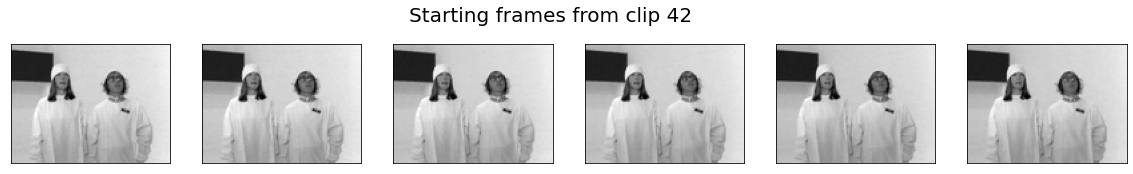

In [28]:
fig, axs = plt.subplots(1, 6, figsize=(20, 20))
st = fig.suptitle('Starting frames from clip 42', fontsize=20)
for i in range(6):
    axs[i].imshow(x[0,i], cmap='gray')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
st.set_y(0.57)

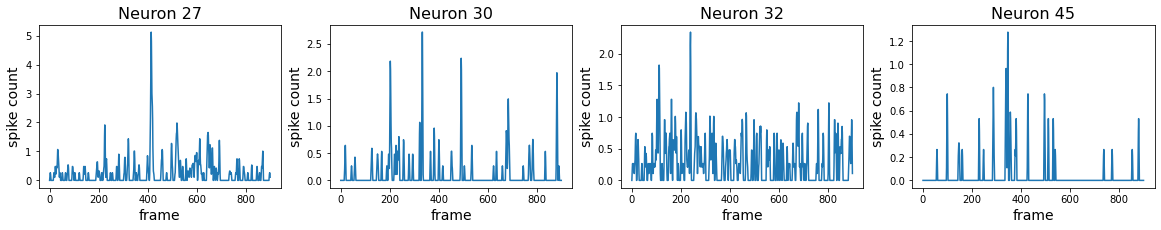

In [55]:
fig, axs = plt.subplots(1, 4, figsize=(20, 3))

def plot_activity(i, idx):
    axs[i].set_title('Neuron {0}'.format(idx), fontsize=16)
    axs[i].plot(y[0,:, idx])
    axs[i].set_xlabel('frame', fontsize=14)
    axs[i].set_ylabel('spike count', fontsize=14)

plot_activity(0, 27)
plot_activity(1, 30)
plot_activity(2, 32)
plot_activity(3, 45)

## 2. Creating the linear-nonlinear model

Now that we have loaded the dataset we can build our model. We construct a simple linear-nonlinear model which is ubiquitously found in systems neuroscience for predicting neuron responses to various stimuli and charactersing neuron receptive fields. Any model must extend the BBModel class found in the models package (as this takes care of bookeeping particular model information and provides useful functions such as weight initialization). There are three functions a model should implement:
1. The \__init__ constructor for defining model variables
2. The hyperparams property which defines the variables we want to store
3. The forward function which defines the models behaviour

In [6]:
class LinearNonlinearModel(models.BBModel):
    
    def __init__(self, n, t, h, w, act='softplus'):
        super().__init__()
        self.n = n
        self.t = t
        self.h = h
        self.w = w
        self.act = act
        
        self.weights = nn.Conv3d(1, n, (t, h, w), bias=True)  
        # This is how we can initialize model weights
        self.init_weight(self.weights.weight, 'normal', mean=0, std=0.0001)
        self.init_weight(self.weights.bias, 'constant', c=0)
    
    @property
    def hyperparams(self):
        return {**super().hyperparams, 'n': self.n, 't': self.t, 'h': self.h, 'w': self.w, 'act_func': self.act}
    
    @property
    def reg_weights(self):
        return [self.weights.weight, self.weights.bias]
    
    @staticmethod
    def get_act_func(act):
        if act == 'sigmoid':
            return torch.sigmoid
        elif act == 'softplus':
            return F.softplus
        elif act == 'elu':
            return F.elu
    
    def forward(self, x):
        x = LinearNonlinearModel.get_act_func(self.act)(self.weights(x))
        
        n_batch, n_chanel, n_timesteps, h, w = x.shape
        assert h == 1 and w == 1, 'Spatial dimensions too large.'
        
        # Ensure output is of shape b x 1 x t x n_neurons
        x = x.view(n_batch, n_chanel, n_timesteps, 1)
        x = x.permute(0, 3, 2, 1)
        
        return x

Now that we have defined our model we can instantiate it. To check that we have stored all the variables of interest we can access the hyperparams property of the model (where we find that all our custom variables are stored in addition to other information such at the model name and weight intilizations that we used).

In [7]:
# Model params
rf_len = 12
act = 'elu'
model = LinearNonlinearModel(n_neurons, rf_len, spatial_h, spatial_w, act=act)
model.hyperparams

{'name': 'LinearNonlinearModel',
 'init_weights.weight': {'name': 'normal', 'mean': 0, 'std': 0.0001},
 'init_weights.bias': {'name': 'constant', 'c': 0},
 'n': 96,
 't': 12,
 'h': 90,
 'w': 120,
 'act_func': 'elu'}

## 3. Training the model

The next step is to train the model we built using the pvc-1 dataset. BrainBox has out-of-the-box trainers which can be found in the trainer package. In our particular use case we want to extend the so called DecayTrainer to not only optimize model prediction, but also penalise large weights using an L1 norm. The DecayTrainer is an implementation taken from Cadena et al., 2019 in which a model is trained on a training dataset and validated on a validation dataset. If the loss starts increasing on the validation dataset the learning rate is decayed. Any instation of a trainer needs to have a loss function implementation (and a val_loss implementation if a validation loss is used). Lastly, out DecayTrainer implementation will keep track of custom loss variables which are the prediction loss and weight loss at every epoch.

In [8]:
class DecayTrainer(trainer.DecayTrainer):
    
    def __init__(self, root, model, train_dataset, val_dataset, n_epochs, batch_size, l1, lr,
                 lr_decay=0.5, max_train_steps=10, max_decay_steps=4, optimizer_func=torch.optim.Adam, device='cuda',
                 dtype=torch.float, grad_clip_type=None, grad_clip_value=None):
        super().__init__(root, model, train_dataset, val_dataset, n_epochs, batch_size, lr, lr_decay, max_train_steps,
                         max_decay_steps, optimizer_func, device, dtype, grad_clip_type, grad_clip_value)
        self.l1 = l1
        
        self.min_loss = np.inf
        self.log = {**self.log, 'pred_loss': [], 'weight_loss': []}
        self.pred_loss = 0
        self.weight_loss = 0
    
    @property
    def hyperparams(self):
        return {**super().hyperparams, 'l1': self.l1}
    
    def on_training_start(self, save):
        pass
    
    def on_epoch_complete(self, save):
        self.log['pred_loss'].append(self.pred_loss)
        self.log['weight_loss'].append(self.weight_loss)
        self.pred_loss = 0
        self.weight_loss = 0
        if save:
            self.save_hyperparams()
        super().on_epoch_complete(save)
    
    def val_loss(self, output, target, model):
        
        # 1. Compute prediction loss
        offset = target.shape[2] - output.shape[2]
        target = target[:, :, offset:]
        pred_loss = F.mse_loss(output, target, reduction='mean')

        return pred_loss
    
    def loss(self, output, target, model):
        
        # 1. Compute prediction loss
        offset = target.shape[2] - output.shape[2]
        target = target[:, :, offset:]
        pred_loss = F.mse_loss(output, target, reduction='mean')

        # 2. Compute weight loss
        weight_loss = 0
        for weights in model.reg_weights:
            weight_loss = (10 ** self.l1) * torch.norm(weights, p=1)
        
        with torch.no_grad():
            self.pred_loss += pred_loss.item()
            self.weight_loss += weight_loss.item()

        loss = pred_loss + weight_loss
        
        return loss

In [9]:
# Trainer params
path = '/home/luketaylor/PycharmProjects/BrainBox/notebooks/misc'
epoch = 1000
batch_size = 10
l1 = -4
lr = -5
lr_decay = 0.5
max_train_steps = 10
max_decay_steps = 4
device = 'cuda'
dtype = torch.float

In [61]:
model_trainer = DecayTrainer(path, model, train_dataset, val_dataset, epoch, batch_size, l1, lr, lr_decay, max_train_steps, max_decay_steps, device=device, dtype=dtype)
model_trainer.train(save=True)

I have taken the courtesy of training the model which we can load with the load_model function. In addition, we can also load associated hyperparameters and losses from the trainer. Storing hyperparameters is useful for us to inspect what variables were set for training and model instantiation at a later stage. Furthermore, the stored losses allow us to debug and select our models (for example if we are training multiple models with different hyperparameters).

In [10]:
model = trainer.load_model(path, model_id='20210724_0340c67d0206454c83fa7d4e92eb2eb4')
hyperparams = trainer.load_hyperparams(path, model_id='20210724_0340c67d0206454c83fa7d4e92eb2eb4')
log = trainer.load_model_log(path, model_id='20210724_0340c67d0206454c83fa7d4e92eb2eb4')

In [14]:
hyperparams

,Unnamed: 0,0
0,train_dataset_name,PVC1Dataset
1,train_dataset_trans_clip_grayscale,{}
2,train_dataset_trans_clip_normalize,"{'mean': [77.88], 'std': [63.44]}"
3,train_dataset_trans_clip_crop,"{'h': 3, 'w': 4}"
4,train_dataset_targ_trans_gaussian_kernel,"{'sigma': 1.5, 'width': 5}"
5,train_dataset_t_len,900
6,train_dataset_dt,1
7,train_dataset_trial_type,single
8,train_dataset_fold_type,train
9,val_dataset_name,PVC1Dataset


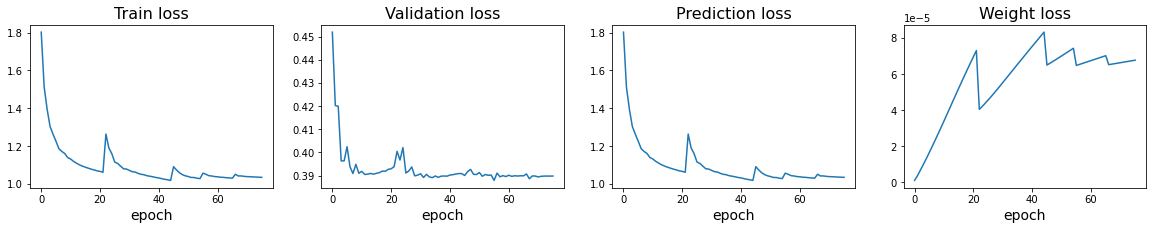

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(20, 3))

def plot_log(i, log, title):
    axs[i].plot(log)
    axs[i].set_title(title, fontsize=16)
    axs[i].set_xlabel('epoch', fontsize=14)
    
plot_log(0, log['train_loss'], 'Train loss')
plot_log(1, log['val_loss'], 'Validation loss')
plot_log(2, log['pred_loss'], 'Prediction loss')
plot_log(3, log['weight_loss'], 'Weight loss')

## 4. Model validation

Now that we have trained our model we can inspect how it performs. We inspect our model quantitatively and qualitatively. BrainBox comes with various GPU optimized metrics which can be found in the metrics package. As a demonstration we inspect the correlation coefficients of our models predictions to the acctual recorded (and smoothed) spike trains.

## 4.1. Quantitative model validation: Correlation coefficients

Below is some example code how we extract model predictions and compute the correlation coefficients for every neuron for every clip using the metrics.cc function. We then filter out neurons that obtain a particular cc value on the validation set (as these are the neurons that are somewhat driven by the natural stimulus). Lastly, we compare the cc value for those neurons on the train, validation and test set. The models correlation coefficients are not particularly high (likely due to the noisy dataset and simple model), maybe you can built a better model for predicting the neural responses?

In [57]:
def compute_cc(dataset, batch_size=10, device='cuda'):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size)
    
    neuron_cc = [[] for _ in range(n_neurons)]
    
    for data, target in data_loader:
        data = data.to(device)
        target = target[:,:,rf_len-1:].to(device)
        output = model(data)
        
        cc = metrics.cc(output, target)
        
        for i in range(n_neurons):
            neuron_cc[i].extend(cc[:,0,i].cpu().detach())
    
    for i in range(n_neurons):
        neuron_cc[i] = np.array(neuron_cc[i])
    
    return neuron_cc

In [58]:
train_neuron_cc = compute_cc(train_dataset)
val_neuron_cc = compute_cc(val_dataset)
test_neuron_cc = compute_cc(test_dataset)

In [141]:
plot_results = []

def build_plot_results(neuron_cc, fold):
    for i in range(n_neurons):
        for cc in neuron_cc[i]:
            plot_results.append({'neuron': i, 'cc': cc, 'fold': fold})
            
build_plot_results(train_neuron_cc, 'train')
build_plot_results(val_neuron_cc, 'val')
build_plot_results(test_neuron_cc, 'test')   
plot_results = pd.DataFrame(plot_results)

valid_neurons = plot_results[plot_results['fold']=='val'].groupby('neuron').mean()['cc'] > 0.05

valid_neuron_idxs = []
for i, valid in enumerate(valid_neurons):
    if valid:
        valid_neuron_idxs.append(i)
        

sub_plot_results = plot_results[plot_results['neuron'].isin(valid_neuron_idxs)]

<AxesSubplot:xlabel='neuron', ylabel='cc'>

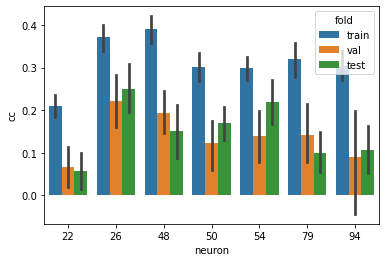

In [173]:
sns.barplot(x='neuron', y='cc', hue='fold', data=sub_plot_results)

## 4.1. Qualitative model validation: Receptive fields

Now for the exciting part we can view some of the receptive fields of the neurons. The linear-nonlinear model has spatiotemporal receptive fields. We can extract the spatial receptive field (which has the largest power) using get_highest_power_spatial_rf function from the physiology package. Cool beans, we observe some receptive fields that are spatially localised!

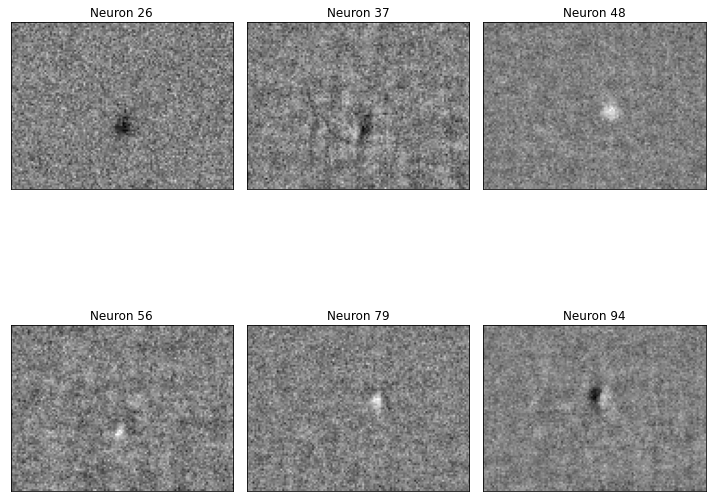

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(10, 10))

def plot_spatial_rf(idx, i, j):
    spatiotemporal_rf = model.weights.weight[idx, 0]
    spatial_rf = phys.get_highest_power_spatial_rf(spatiotemporal_rf).detach().cpu()
    v_max = spatial_rf.abs().max()
    axs[i, j].set_title('Neuron {0}'.format(idx))
    axs[i, j].imshow(spatial_rf, vmin=-v_max, vmax=v_max, cmap='gray')
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])

plot_spatial_rf(26, 0, 0)
plot_spatial_rf(37, 0, 1)
plot_spatial_rf(48, 0, 2)
plot_spatial_rf(56, 1, 0)
plot_spatial_rf(79, 1, 1)
plot_spatial_rf(94, 1, 2)
fig.tight_layout()